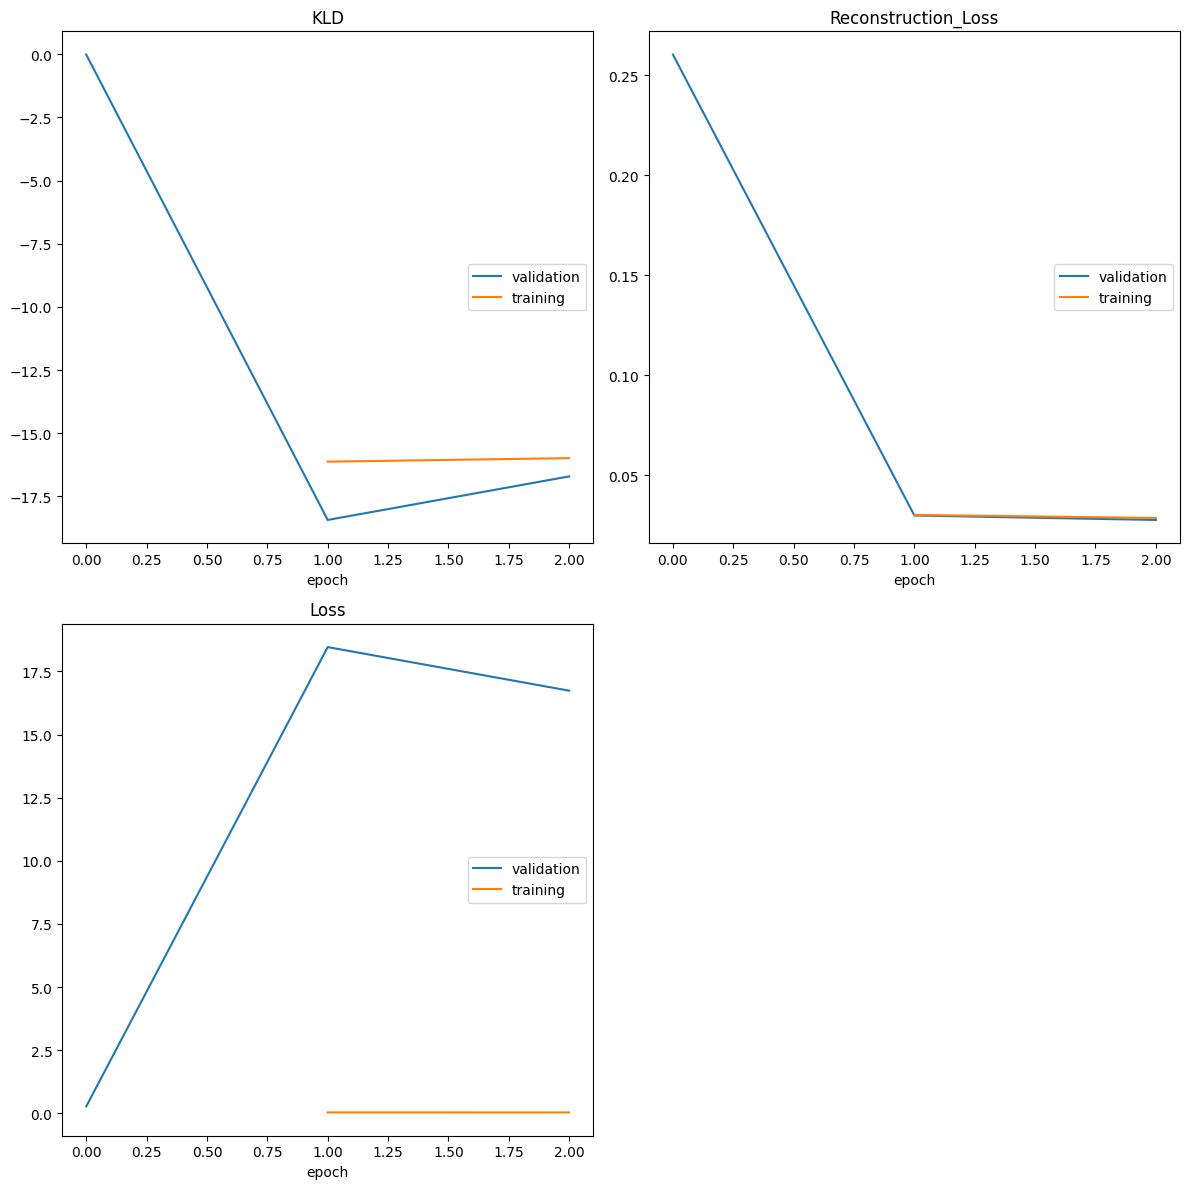

Validation: 0it [00:00, ?it/s]

In [ ]:
import os
import yaml
import argparse
import numpy as np
from pathlib import Path
from models import *
from experiment import VAEXperiment
import torch.backends.cudnn as cudnn
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from dataset import VAEDataset
from MetricsTracker import MetricTracker

torch.set_float32_matmul_precision('medium')

with open("./configs/cvae.yaml", 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)


tb_logger = TensorBoardLogger(save_dir=config['logging_params']['save_dir'],
                               name=config['model_params']['name'],)
model = vae_models[config['model_params']['name']](**config['model_params'])
experiment = VAEXperiment(
    model,
    config['exp_params']
)
metric_tracker = MetricTracker()
data = VAEDataset(**config["data_params"], pin_memory=config['trainer_params']['accelerator'] != 'gpu')
data.setup()

runner = Trainer(logger=tb_logger,
                 callbacks=[
                     metric_tracker,
                     LearningRateMonitor(),
                     ModelCheckpoint(save_top_k=2, 
                                     dirpath =os.path.join(tb_logger.log_dir , "checkpoints"), 
                                     monitor= "val_loss",
                                     save_last= True),
                 ],
                 **config['trainer_params'])


Path(f"{tb_logger.log_dir}/Samples").mkdir(exist_ok=True, parents=True)
Path(f"{tb_logger.log_dir}/Reconstructions").mkdir(exist_ok=True, parents=True)


print(f"======= Training {config['model_params']['name']} =======")
runner.fit(experiment, datamodule=data)